In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Set matplotlib to display in notebook
%matplotlib inline
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class DemosaicingDataset(Dataset):
    def __init__(self, root_dir, split_file, patch_size=33, stride=33, transform=None):
        """Initialize Demosaicing dataset"""
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform
        
        # Read image list from split file
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
            
        print(f"Found {len(self.image_files)} images in {os.path.basename(split_file)}")
        
        # Pre-compute patches
        self.patches = self._prepare_patches()
        
    def _prepare_patches(self):
        """Prepare patches from all images"""
        patches = []
        
        for i, img_file in enumerate(self.image_files):
            print(f"Processing image {i+1}/{len(self.image_files)}", end='\r')
            
            # Load ground truth image
            gt_path = os.path.join(self.groundtruth_dir, img_file)
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            
            # Load input image (raw Bayer)
            input_path = os.path.join(self.input_dir, img_file)
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            
            # Normalize input to [0, 1]
            input_img = input_img.astype(np.float32) / 65535.0
            gt_img = gt_img.astype(np.float32) / 255.0
            
            # Extract patches
            h, w = input_img.shape
            for i in range(0, h - self.patch_size + 1, self.stride):
                for j in range(0, w - self.patch_size + 1, self.stride):
                    input_patch = input_img[i:i+self.patch_size, j:j+self.patch_size]
                    gt_patch = gt_img[i:i+self.patch_size, j:j+self.patch_size]
                    
                    # Skip patches with low variance
                    if input_patch.std() > 0.02:
                        patches.append({
                            'input': input_patch,
                            'target': gt_patch,
                            'image_file': img_file,
                            'position': (i, j)
                        })
        
        print(f"\nExtracted {len(patches)} valid patches")
        return patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        # Convert to torch tensors
        input_tensor = torch.from_numpy(patch['input']).float().unsqueeze(0)
        target_tensor = torch.from_numpy(patch['target']).float().permute(2, 0, 1)
        
        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)
            
        return {
            'input': input_tensor,
            'target': target_tensor,
            'image_file': patch['image_file'],
            'position': patch['position']
        }

In [3]:
def prepare_demosaicing_datasets(dataset_path, batch_size=32, num_workers=4):
    """Prepare training, validation and test datasets and dataloaders"""
    split_files = {
        'train': os.path.join(dataset_path, 'train.txt'),
        'val': os.path.join(dataset_path, 'validation.txt'),
        'test': os.path.join(dataset_path, 'test.txt')
    }
    
    datasets = {}
    dataloaders = {}
    
    for split_name, split_file in split_files.items():
        if os.path.exists(split_file):
            print(f"\nPreparing {split_name} dataset...")
            
            # Create dataset
            datasets[f'{split_name}_dataset'] = DemosaicingDataset(
                root_dir=dataset_path,
                split_file=split_file,
                patch_size=33,
                stride=33
            )
            
            # Create dataloader
            dataloaders[f'{split_name}_loader'] = DataLoader(
                datasets[f'{split_name}_dataset'],
                batch_size=batch_size,
                shuffle=(split_name == 'train'),
                num_workers=num_workers,
                pin_memory=True
            )
        else:
            print(f"Warning: {split_file} not found. Skipping {split_name} split.")
    
    return {**datasets, **dataloaders}

# Prepare datasets
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
data = prepare_demosaicing_datasets(dataset_path=dataset_path, batch_size=32, num_workers=4)

# Print statistics
print("\nDataset Statistics:")
print("-" * 50)
for split in ['train', 'val', 'test']:
    if f'{split}_dataset' in data:
        print(f"{split.capitalize()} samples: {len(data[f'{split}_dataset'])}")


Preparing train dataset...
Found 200 images in train.txt
Processing image 200/200
Extracted 4396 valid patches

Preparing val dataset...
Found 100 images in validation.txt
Processing image 100/100
Extracted 2288 valid patches

Preparing test dataset...
Found 200 images in test.txt
Processing image 200/200
Extracted 4369 valid patches

Dataset Statistics:
--------------------------------------------------
Train samples: 4396
Val samples: 2288
Test samples: 4369


In [4]:
class DMCNN(torch.nn.Module):
    """DMCNN for image demosaicing
    Model adopted from https://arxiv.org/pdf/1802.03769.pdf
    """
    def __init__(self):
        super(DMCNN, self).__init__()
        
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Conv2d(1, 128, kernel_size=9, padding=4),
            torch.nn.ReLU()
        )
        
        self.mapping_layer = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU()
        )
        
        self.reconstruction_layer = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=5, padding=2),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.feature_layer(x)
        out = self.mapping_layer(out)
        out = self.reconstruction_layer(out)
        return out

# Initialize model
model = DMCNN().to(device)

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for i, batch in enumerate(train_loader):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        if (i + 1) % 10 == 0:
            print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.6f}', end='\r')
    
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            
            if (i + 1) % 10 == 0:
                print(f'Val Batch [{i+1}/{len(val_loader)}], Loss: {loss.item():.6f}', end='\r')
    
    return running_loss / len(val_loader.dataset)

def plot_results(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

Starting training...

Epoch [1/500]
Val Batch [70/72], Loss: 0.007127
Epoch [1/500]
Train Loss: 0.011182
Val Loss: 0.006474

Epoch [2/500]
Val Batch [70/72], Loss: 0.006781
Epoch [2/500]
Train Loss: 0.005926
Val Loss: 0.005462

Epoch [3/500]
Val Batch [70/72], Loss: 0.006219
Epoch [3/500]
Train Loss: 0.005670
Val Loss: 0.004866

Epoch [4/500]
Val Batch [70/72], Loss: 0.004643
Epoch [4/500]
Train Loss: 0.003875
Val Loss: 0.003727

Epoch [5/500]
Val Batch [70/72], Loss: 0.003469
Epoch [5/500]
Train Loss: 0.004065
Val Loss: 0.003325

Epoch [6/500]
Val Batch [70/72], Loss: 0.003179
Epoch [6/500]
Train Loss: 0.002920
Val Loss: 0.003182

Epoch [7/500]
Val Batch [70/72], Loss: 0.003481
Epoch [7/500]
Train Loss: 0.003119
Val Loss: 0.003052

Epoch [8/500]
Val Batch [70/72], Loss: 0.003935
Epoch [8/500]
Train Loss: 0.002985
Val Loss: 0.003982

Epoch [9/500]
Val Batch [70/72], Loss: 0.003652
Epoch [9/500]
Train Loss: 0.002560
Val Loss: 0.003031

Epoch [10/500]
Val Batch [70/72], Loss: 0.027326
Ep

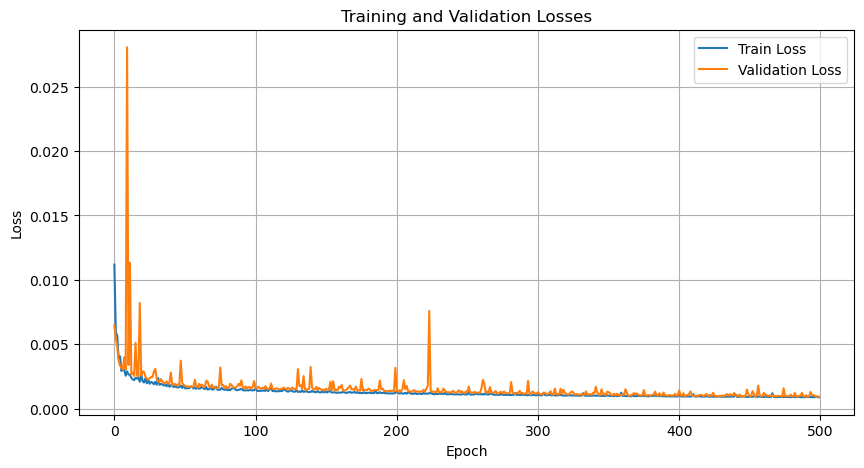

In [6]:
# Training setup
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    params=[
        {"params": model.feature_layer.parameters(), "lr": 1},
        {"params": model.mapping_layer.parameters(), "lr": 1},
        {"params": model.reconstruction_layer.parameters(), "lr": 0.1}
    ]
)

# Training parameters
n_epochs = 500
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Training loop
print("Starting training...")
for epoch in range(n_epochs):
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    
    # Train
    train_loss = train_epoch(model, data['train_loader'], criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, data['val_loader'], criterion, device)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_dmcnn_model.pth')
    
    # Print epoch results
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    print(f'Train Loss: {train_loss:.6f}')
    print(f'Val Loss: {val_loss:.6f}')

# Plot training results
plot_results(train_losses, val_losses)

Loaded model from epoch 499 with validation loss 0.000929


/tmp/ipykernel_1986766/324289335.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_dmcnn_model.pth')


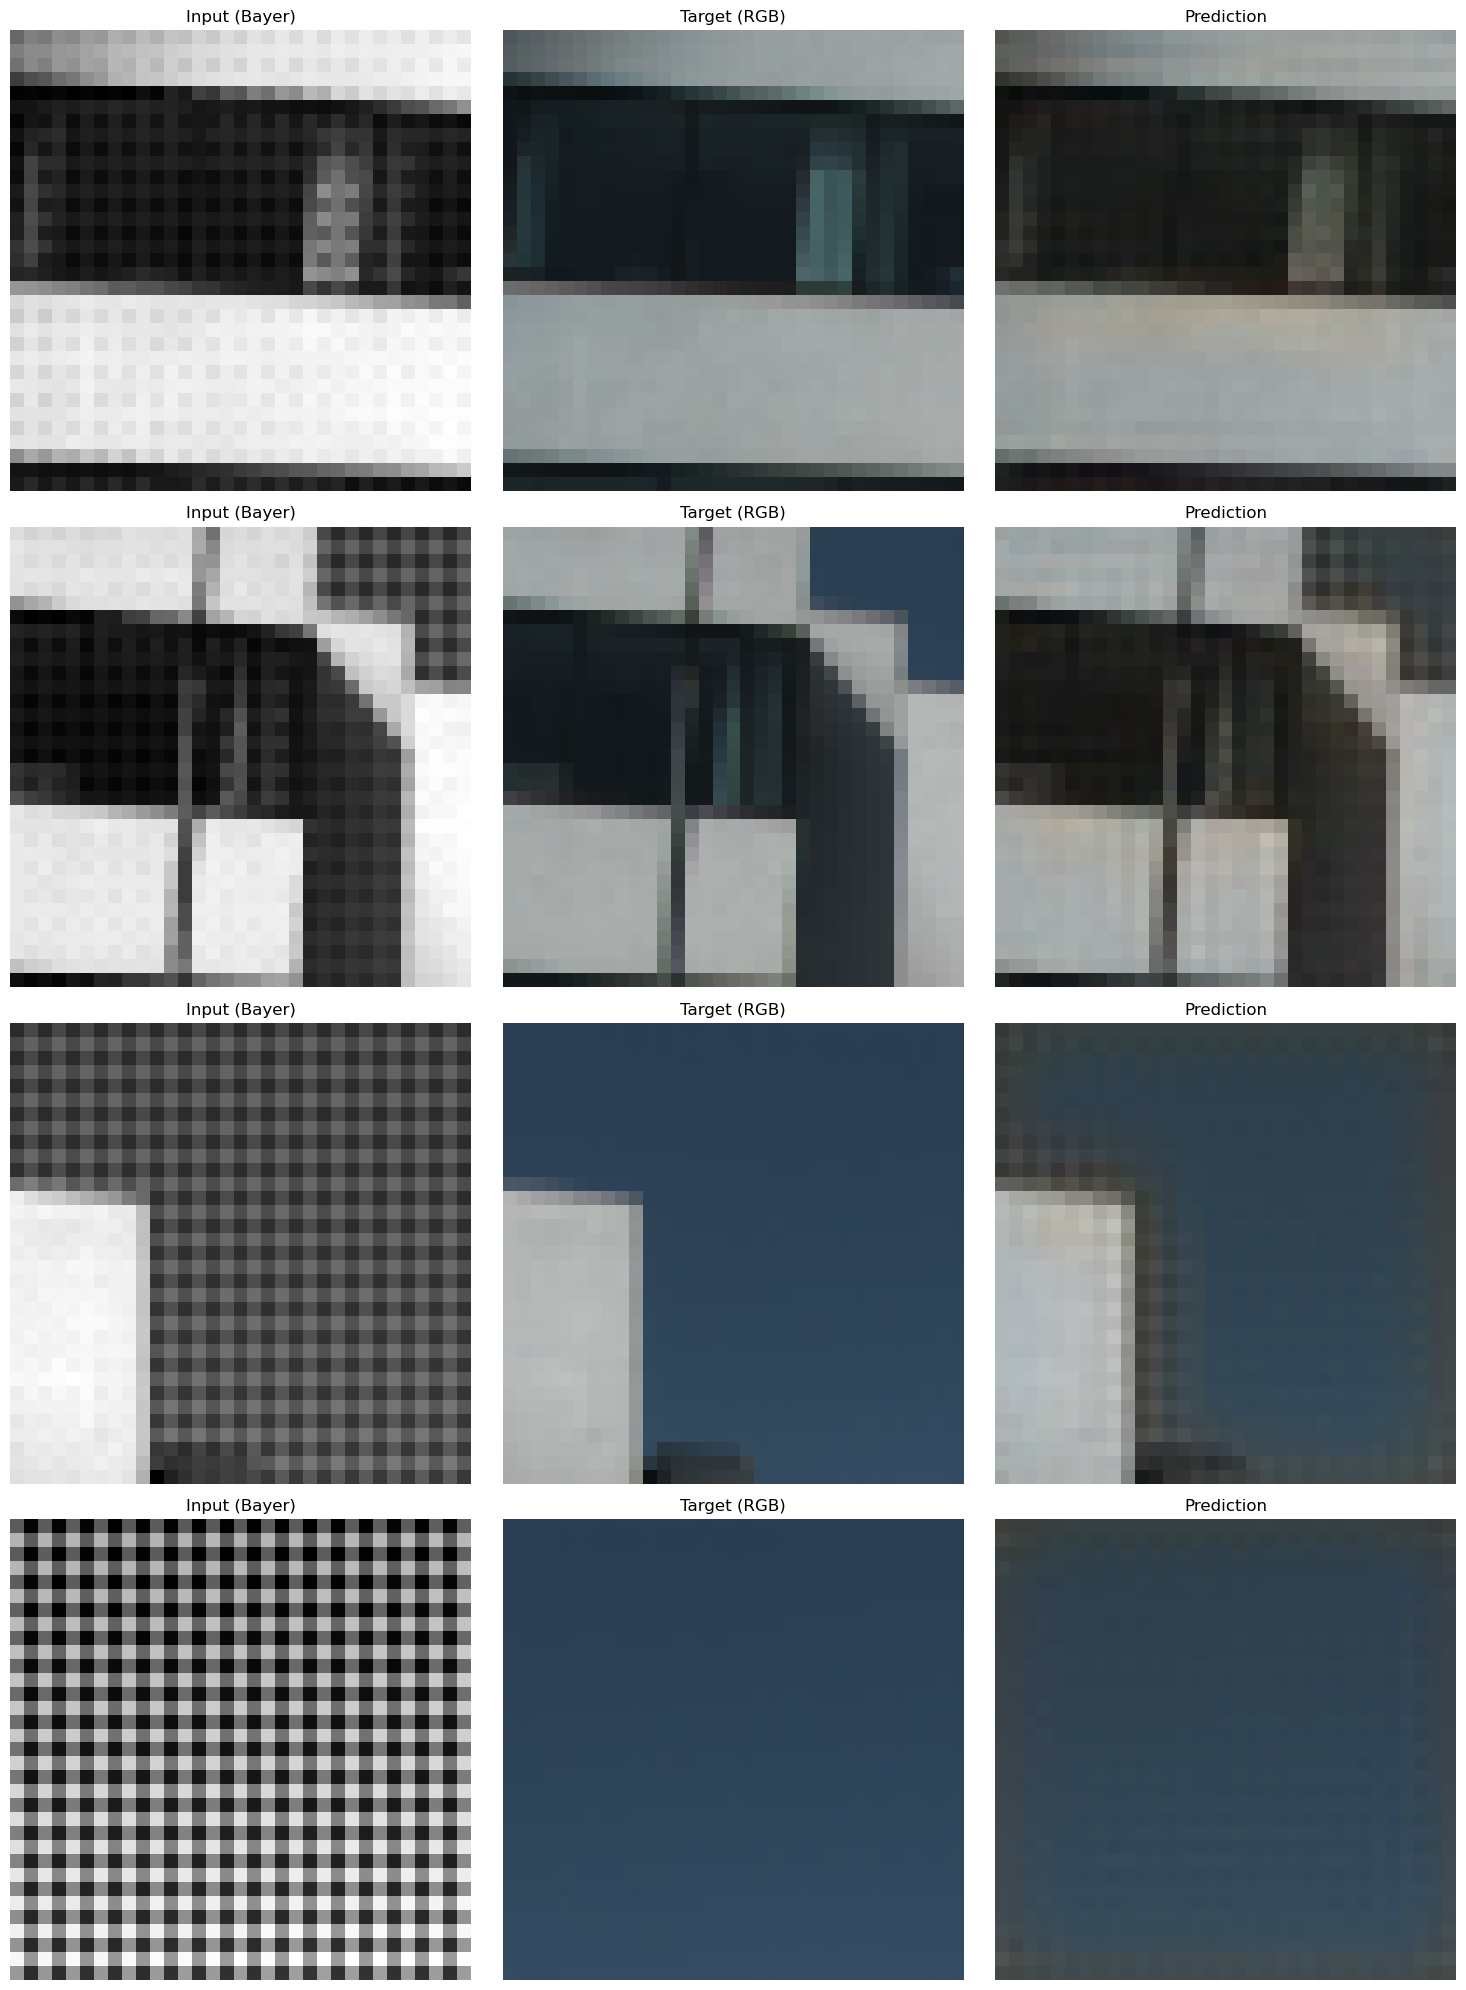

In [7]:
def visualize_results(model, test_loader, device, num_samples=4):
    """Visualize model predictions"""
    model.eval()
    
    batch = next(iter(test_loader))
    inputs = batch['input'].to(device)
    targets = batch['target']
    
    with torch.no_grad():
        outputs = model(inputs)
    
    num_samples = min(num_samples, len(inputs))
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Input
        axes[i, 0].imshow(inputs[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Input (Bayer)')
        axes[i, 0].axis('off')
        
        # Target
        axes[i, 1].imshow(targets[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title('Target (RGB)')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load best model and visualize results
checkpoint = torch.load('best_dmcnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.6f}")

visualize_results(model, data['test_loader'], device)

Processing full image: 100.png


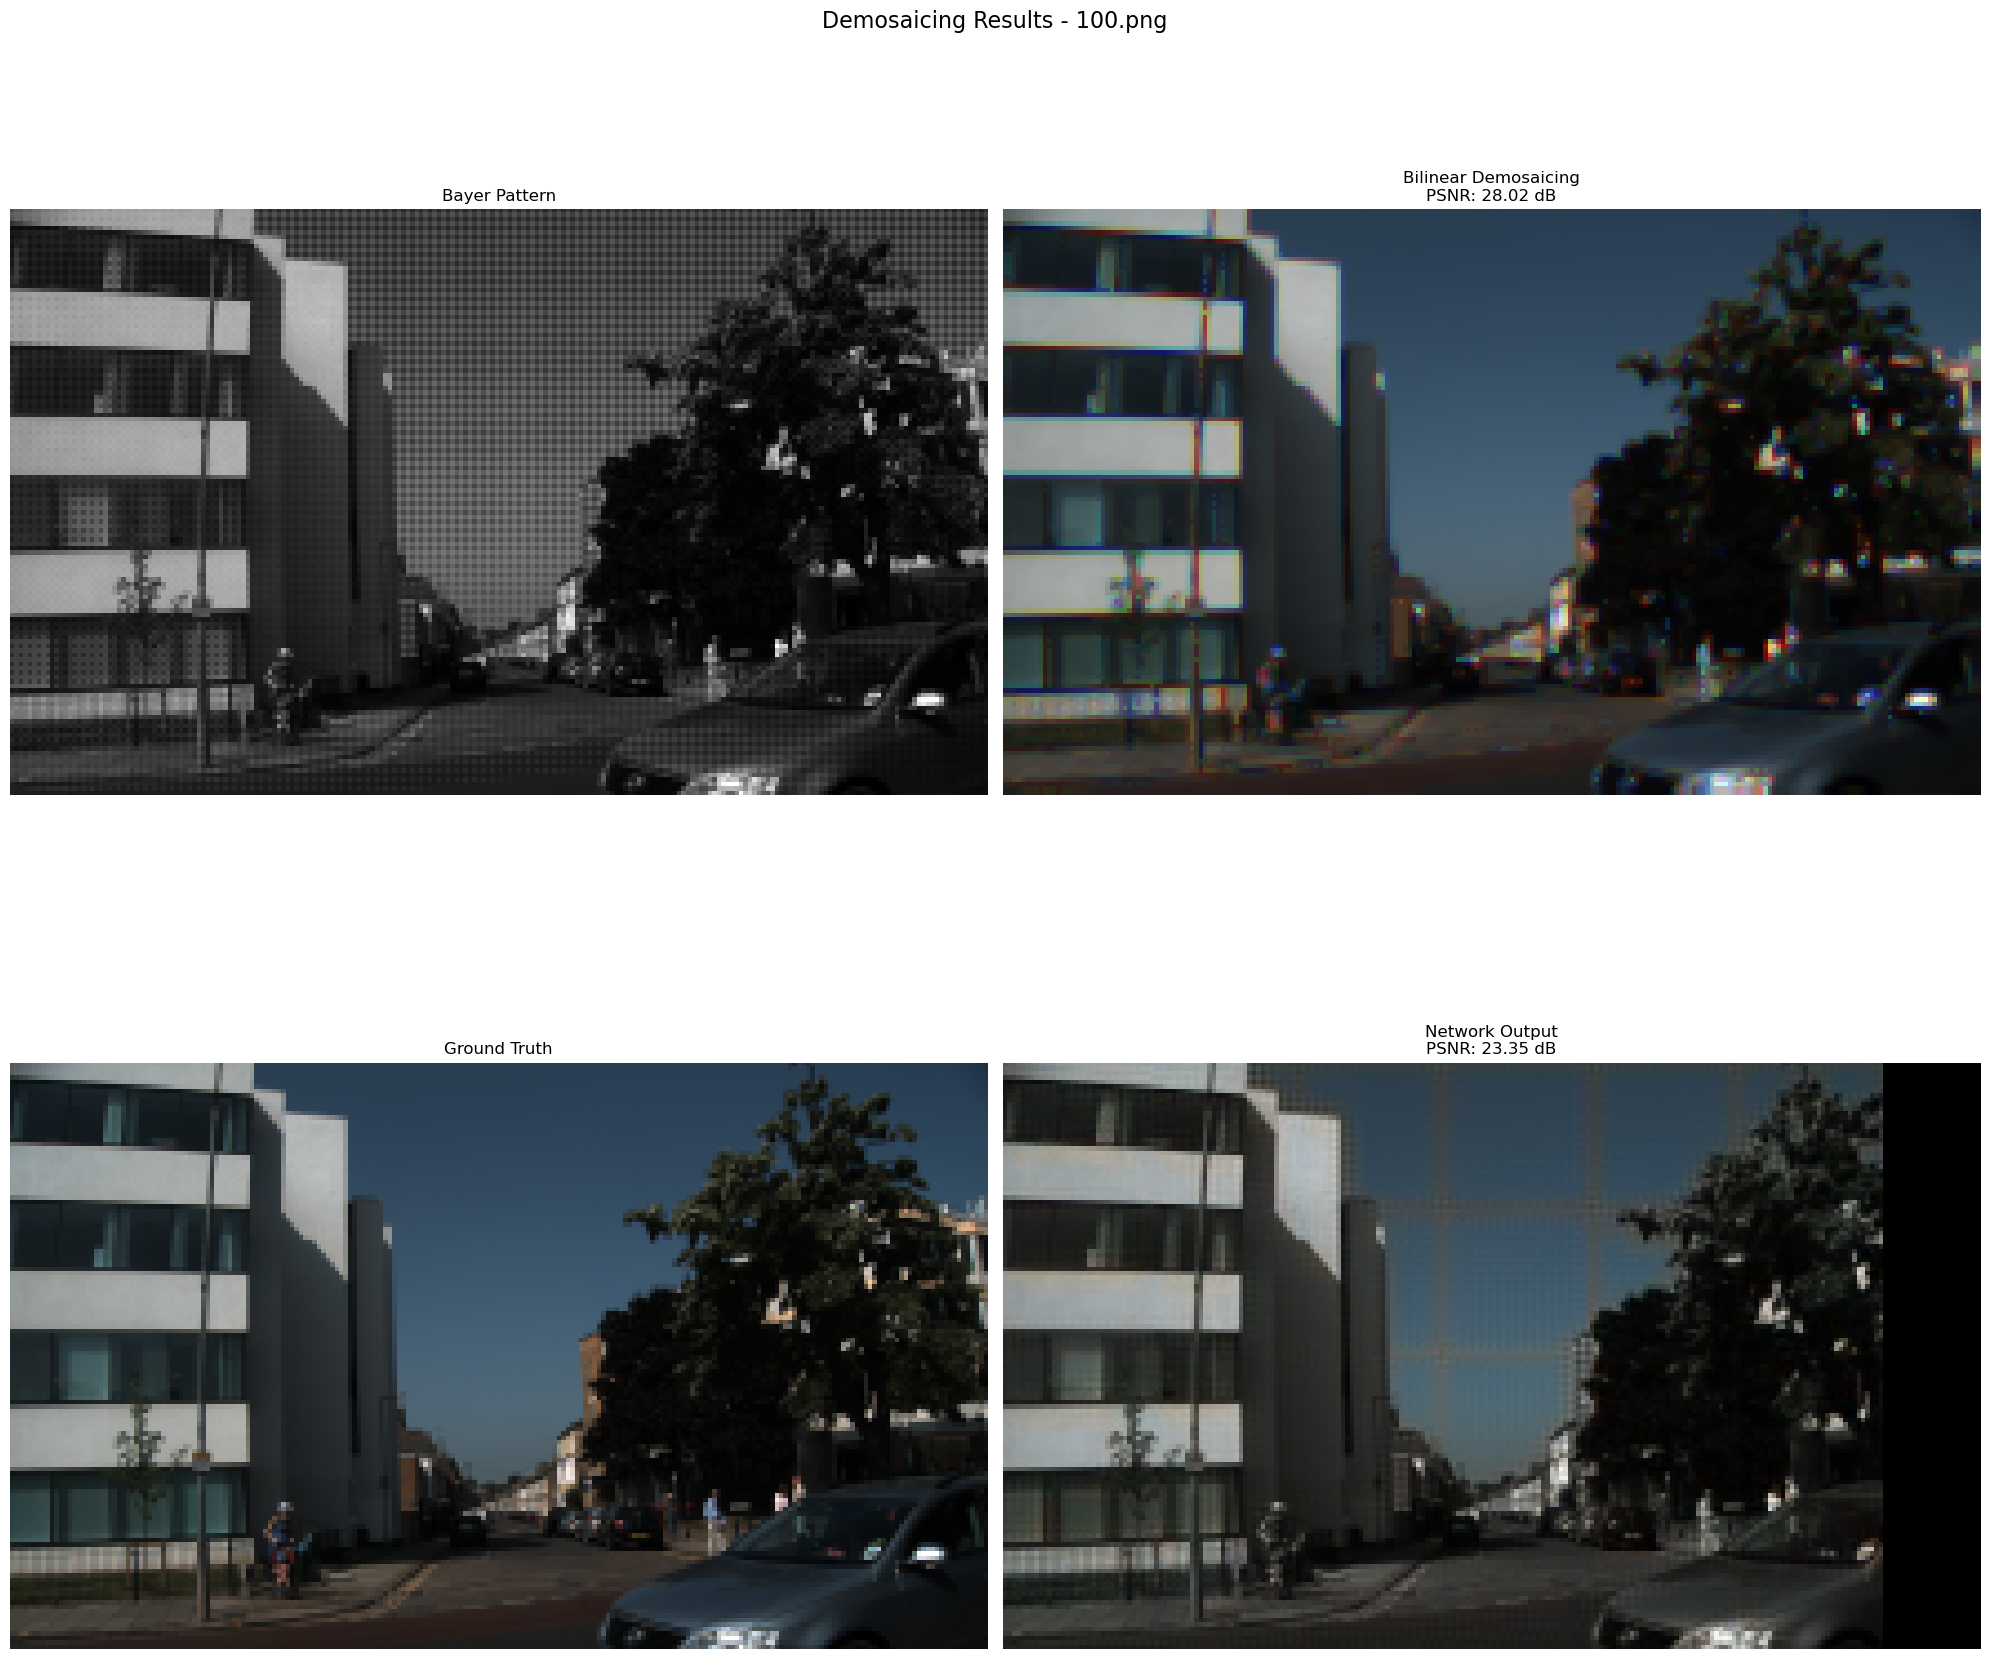


Quantitative Results:
Bilinear PSNR: 28.02 dB
Network PSNR: 23.35 dB
PSNR Improvement: -4.66 dB


In [8]:
def reconstruct_and_compare(model, test_loader, device):
    """
    Reconstruct full images from patches and compare different demosaicing methods
    """
    model.eval()
    
    # Get a batch
    batch = next(iter(test_loader))
    
    # Get original image name and load full images
    img_file = batch['image_file'][0]  # Get first image name from batch
    
    # Load full input image (Bayer)
    input_path = os.path.join(data['test_dataset'].input_dir, img_file)
    input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    bayer_img = input_img.astype(np.float32) / 65535.0  # Normalize to [0,1]
    
    # Load full ground truth image
    gt_path = os.path.join(data['test_dataset'].groundtruth_dir, img_file)
    gt_img = cv2.imread(gt_path)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_img = gt_img.astype(np.float32) / 255.0  # Normalize to [0,1]
    
    # Create bilinear interpolation
    bayer_uint8 = (bayer_img * 255).astype(np.uint8)
    bilinear = cv2.cvtColor(bayer_uint8, cv2.COLOR_BAYER_BG2RGB_EA)
    bilinear = bilinear.astype(np.float32) / 255.0
    
    # Process full image with our network in patches
    patch_size = data['test_dataset'].patch_size
    stride = patch_size  # Non-overlapping patches for simplicity
    h, w = bayer_img.shape
    output_img = np.zeros((h, w, 3), dtype=np.float32)
    count = np.zeros((h, w, 3), dtype=np.float32)
    
    print(f"Processing full image: {img_file}")
    with torch.no_grad():
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                # Extract patch
                patch = bayer_img[i:i+patch_size, j:j+patch_size]
                
                # Convert to tensor
                patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0)
                patch_tensor = patch_tensor.to(device)
                
                # Process patch
                output_patch = model(patch_tensor)
                output_patch = output_patch.squeeze().cpu().numpy()
                output_patch = np.transpose(output_patch, (1, 2, 0))
                
                # Add to output image
                output_img[i:i+patch_size, j:j+patch_size] += output_patch
                count[i:i+patch_size, j:j+patch_size] += 1
    
    # Average overlapping regions
    output_img = np.divide(output_img, count, where=count!=0)
    
    # Calculate PSNR
    def calculate_psnr(img1, img2):
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return float('inf')
        return 20 * np.log10(1.0 / np.sqrt(mse))
    
    bilinear_psnr = calculate_psnr(gt_img, bilinear)
    network_psnr = calculate_psnr(gt_img, output_img)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Bayer pattern
    axes[0, 0].imshow(bayer_img, cmap='gray')
    axes[0, 0].set_title('Bayer Pattern')
    axes[0, 0].axis('off')
    
    # Bilinear demosaicing
    axes[0, 1].imshow(np.clip(bilinear, 0, 1))
    axes[0, 1].set_title(f'Bilinear Demosaicing\nPSNR: {bilinear_psnr:.2f} dB')
    axes[0, 1].axis('off')
    
    # Ground truth
    axes[1, 0].imshow(gt_img)
    axes[1, 0].set_title('Ground Truth')
    axes[1, 0].axis('off')
    
    # Our network output
    axes[1, 1].imshow(np.clip(output_img, 0, 1))
    axes[1, 1].set_title(f'Network Output\nPSNR: {network_psnr:.2f} dB')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'Demosaicing Results - {img_file}', y=0.95, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print quantitative results
    print("\nQuantitative Results:")
    print(f"Bilinear PSNR: {bilinear_psnr:.2f} dB")
    print(f"Network PSNR: {network_psnr:.2f} dB")
    print(f"PSNR Improvement: {network_psnr - bilinear_psnr:.2f} dB")

# Test the reconstruction
reconstruct_and_compare(model, data['test_loader'], device)